In [6]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib
#Set a vetor of discretized cake sizes
W_lb = 1e-2
W_ub = 1.0
N = 1000
W_vec = np.linspace(W_lb, W_ub, N)
#Create utility matrix
c_mat = np.tile(W_vec.reshape((N,1)), (1,N)) - np.tile(W_vec.reshape((1,N)), (N,1))
c_pos = c_mat>0

#Set a vector of iid shocks
sigma = 0.5
M = 7
mu = 4*sigma
e_ub = mu+3*sigma #lower bound
e_lb = mu-3*sigma #upper bound
N = 1000
epsilon = np.linspace(e_lb, e_ub, M) 
e_vec = np.linspace(e_lb, e_ub, M)
e_midpts = e_vec[:-1]+0.5*(e_vec[1:]-e_vec[:-1])

gamma = np.zeros(M)
for e_ind in range(M):
    if e_ind==0:
        gamma[e_ind]=sts.norm.cdf(e_midpts[e_ind], loc=mu, scale=sigma)
    elif e_ind>0 and e_ind<M-1:
        gamma[e_ind] = (sts.norm.cdf(e_midpts[e_ind], mu, sigma))-(sts.norm.cdf(e_midpts[e_ind-1], mu, sigma))
    elif e_ind == M-1:
        gamma[e_ind]=1-sts.norm.cdf(e_midpts[e_ind-1], mu, sigma)
print(gamma)
gamma.sum()

[0.00620967 0.06059754 0.24173034 0.38292492 0.24173034 0.06059754
 0.00620967]


1.0

In [7]:
#set other paramterers (discount factor)
beta = 0.9
#choose a utility function u(c)=log(c)
def utility(c):
    util = np.log(c)
    return util

In [8]:
pr_e_mat = np.tile(gamma.reshape(1,M), (N,1))
W_arr = np.tile(W_vec.reshape(N,1,1), (1,M,N))
W_prime_arr = np.tile(W_vec.reshape(1,1,N), (N,M,1))
c_pos_arr = np.tile(c_pos.reshape(N,1,N), (1,M,1))
e_arr = np.tile(gamma.reshape(1,M,1), (N,1,N))
c_arr = W_arr - W_prime_arr
c_arr[~c_pos_arr] = 1e-4
u_arr = utility(c_arr)*e_arr

In [9]:
maxiters = 500
toler = 1e-9
delta = 10.0
VF_iter = 0
V_init = np.zeros((N,M))
dist = 1e10

while (dist>toler) and (VF_iter < maxiters):
    VF_iter += 1
    
    Exp_V_pr = (pr_e_mat * V_init).sum(axis=1) #Expected utility d(M*1)
    Exp_V_pr_arr = np.tile(Exp_V_pr.reshape((1,1,N)), (N,M,1)) #(N,M,N)
    #Set all elements of the expected value cube that corresponds to negative consumption to a large negative number
    Exp_V_pr_arr[~c_pos_arr] = -9e4
    
    #Contraction
    V_new = (u_arr + beta * Exp_V_pr_arr).max(axis=2)
    
    #Get the policy function
    W_index = (u_arr + beta * Exp_V_pr_arr).argmax(axis=2)
    W = W_vec[W_index]
    
    #Update the distance
    dist = ((V_new - V_init)**2).sum()
    
    V_init = V_new
    print('Iter=', VF_iter, ', distance= ', dist)
    

Iter= 1 , distance=  45928492634.41968
Iter= 2 , distance=  37203163999.13076
Iter= 3 , distance=  30134564046.041252
Iter= 4 , distance=  24408997591.93116
Iter= 5 , distance=  19771288534.105957
Iter= 6 , distance=  16014744059.912958
Iter= 7 , distance=  12971942945.667898
Iter= 8 , distance=  10507273980.620045
Iter= 9 , distance=  8510892073.975945
Iter= 10 , distance=  6893822696.406207
Iter= 11 , distance=  5583996475.614225
Iter= 12 , distance=  4523037217.7172365
Iter= 13 , distance=  3663660204.102656
Iter= 14 , distance=  2967564811.6059394
Iter= 15 , distance=  2403727534.676833
Iter= 16 , distance=  1947019333.2442603
Iter= 17 , distance=  1577085684.4264781
Iter= 18 , distance=  1277439424.3687944
Iter= 19 , distance=  1034725950.103772
Iter= 20 , distance=  838128033.039797
Iter= 21 , distance=  678883717.8716052
Iter= 22 , distance=  549895820.6880664
Iter= 23 , distance=  445415622.43139243
Iter= 24 , distance=  360786660.5934067
Iter= 25 , distance=  292237200.48683
I

<IPython.core.display.Javascript object>


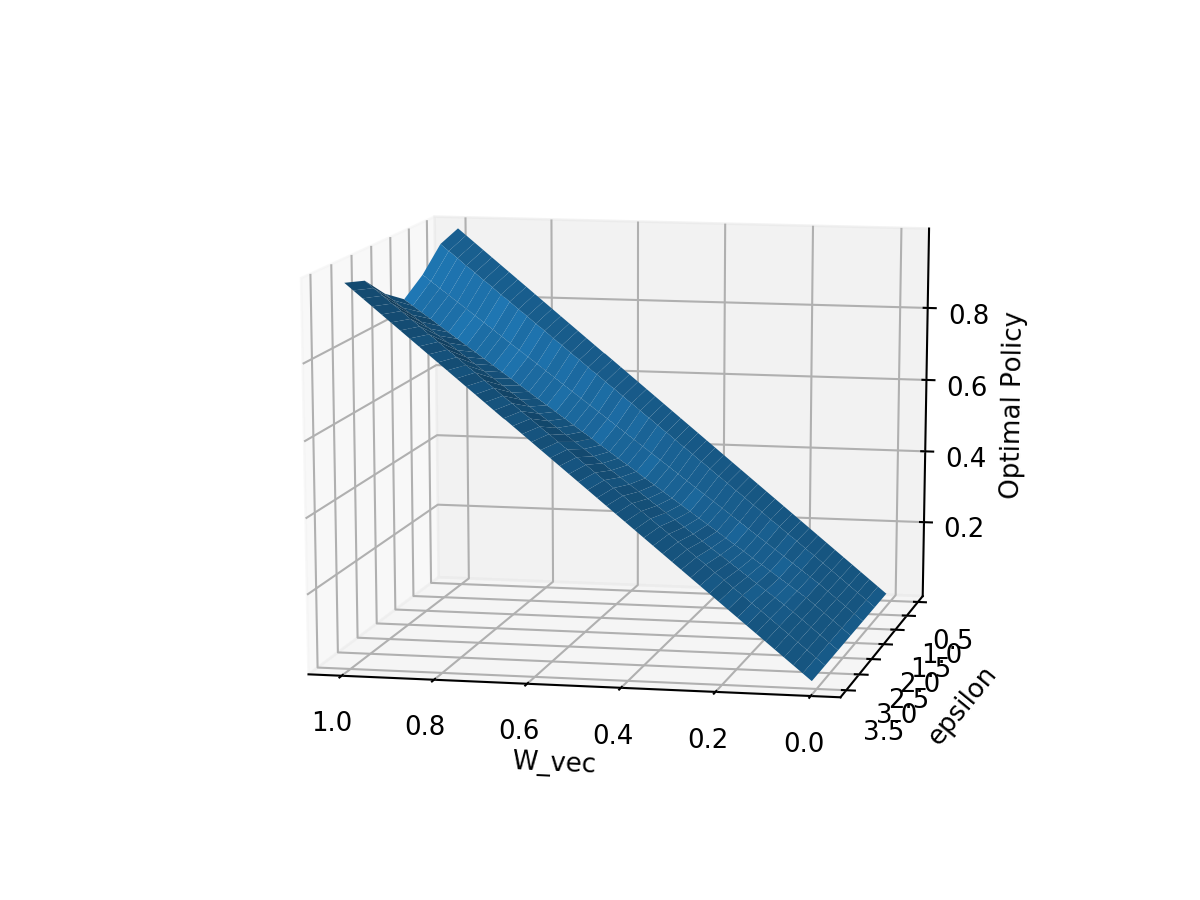

In [11]:
%matplotlib notebook
from mpl_toolkits import mplot3d
X, Y = np.meshgrid(W_vec, epsilon)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X.T, Y.T, W)
ax.set_xlabel('W_vec')
ax.set_ylabel('epsilon')
ax.set_zlabel('Optimal Policy')
ax.view_init(elev=60,azim=30)
plt.show()